# Red Cross detection and classification demo workflow

In [1]:
import os
import json
import glob
from random import shuffle

import cv2
import numpy as np
import torch
from torchmetrics import detection, F1Score
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor
from detectron2.engine.defaults import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rasterio
import pandas as pd

In [2]:
import sys
sys.path.append("../")


from src.datamodule import HouseDataModule
from src.model import HPClassifier
from detect_clip_classify import evaluate_classification_model, clip_image_around_bbox_buffer, load_classification_model
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, ToPILImage

In [3]:
import torch, detectron2

### Load the model

In [4]:
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(                                                                                                                              
    "ericfrench2015/street_level_building_detection", "model_final.pth"                                                                                    
)                                                                                                                                                          
config_path = hf_hub_download(                                                                                                                             
    "ericfrench2015/street_level_building_detection", "config.yml"                                                                                         
)

cfg = get_cfg()                                                                                                                                            
cfg.merge_from_file(config_path)                                                                                                                           
cfg.MODEL.WEIGHTS = model_path  # Directly use the downloaded model                                                                                        
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"                                                                                          
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set confidence threshold

In [5]:
predictor = DefaultPredictor(cfg)

### Run inference

In [6]:
# In case we'd like to store our test images with inferences plotted
inference_image_output = "./output/test_inference_images/"
os.makedirs(inference_image_output, exist_ok=True)

#### Generate predictions on an example image

In [7]:
# Random example image
data_dir = "./data/"
fn = "BuildingD-ALBERTANDVERALISTACADEMICCENTER.jpg"

# Example image from mapillary
data_dir = "../data/images_new/Qycm8N0gHbjkBZCtdxMoY3/"
fn = "1498749314134807_front.jpg"

fp = os.path.join(data_dir, fn)

In [8]:
im = cv2.imread(fp)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
pred_image = out.get_image()[:, :, ::-1]
cv2.imwrite(f"{inference_image_output}{fn.replace('/', '_')}", out.get_image()[:, :, ::-1])

/opt/miniconda3/envs/hp/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


True

#### Visualize one of the resulting images

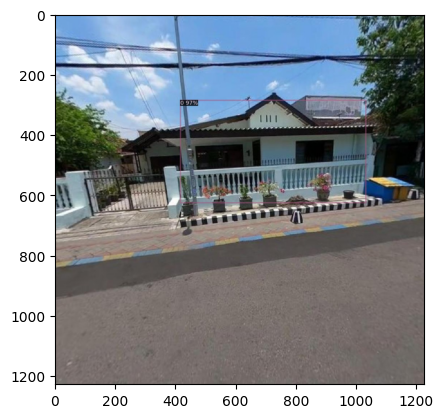

In [9]:
import matplotlib.image as mpimg

# Specify the path to your image
image_path = f'{inference_image_output}/{fn}'

# Load the image using matplotlib.image.imread
img = mpimg.imread(image_path)

# Plot the image using matplotlib.pyplot.imshow
plt.imshow(img)

#### Generate predictions and plot them on some subset of the test dataset

In [10]:
outputs["instances"].pred_boxes

Boxes(tensor([[346.2761, 238.9630, 859.1562, 522.7247]]))

In [11]:
box_ind = 0
bb, sc = list(zip(outputs["instances"].pred_boxes, outputs["instances"].scores))[box_ind]

In [12]:
bb

tensor([346.2761, 238.9630, 859.1562, 522.7247])

In [13]:
bbox_data = bb.tolist() 
clipped_img = clip_image_around_bbox_buffer(im, bbox_data)
img = torch.tensor(clipped_img.transpose(2,0,1)).to(torch.float32)
img = ToPILImage()(img)
transform = Compose([
    Resize((512,512), antialias=True),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img = transform(img)
img = img.unsqueeze(0)
image_clipped_output_dirs = fn.split('/')

In [14]:
clipped_data_dir = f"{inference_image_output}/clips"
os.makedirs(clipped_data_dir, exist_ok=True)

In [15]:
clipped_fn = f"{fn[:-4]}_{box_ind}.jpg"
clipped_fp = os.path.join(clipped_data_dir, clipped_fn)

In [16]:
cv2.imwrite(clipped_fp, clipped_img)

True

#### Visualize clipped image

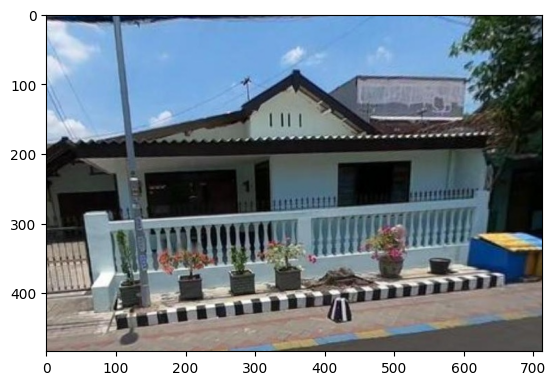

In [17]:
# Load the image using matplotlib.image.imread
img = mpimg.imread(clipped_fp)

# Plot the image using matplotlib.pyplot.imshow
plt.imshow(img)